In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')



# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [2]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.tail()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
2019-10-09,9381.0,9391.5,9330.5,9343.5,38.5,9338.0,99153.0,145470.0
2019-10-10,9343.5,9380.5,9293.5,9301.0,34.5,9303.5,159397.0,144474.0
2019-10-11,9308.5,9309.0,9240.0,9267.0,52.5,9251.0,158810.0,147471.0
2019-10-14,9259.0,9292.0,9250.5,9261.0,14.0,9265.0,69457.0,153902.0
2019-10-15,9264.5,9280.0,9216.5,9220.0,43.5,9221.5,108342.0,151564.0


In [381]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

<AxesSubplot:xlabel='Date'>

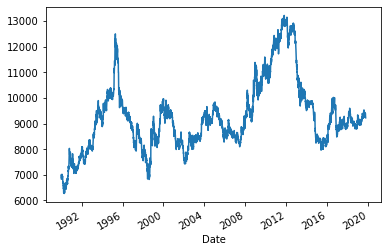

In [382]:
# Plot just the "Settle" column from the dataframe:

yen_futures.Settle.plot()


---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [383]:
import statsmodels.api as sm


file_path = Path("yen.csv")
yen_futures = pd.read_csv(file_path, index_col='Date', infer_datetime_format=True, parse_dates=True)
yen_futures.head()

# Use the `hpfilter` function to decompose the Settle column into the trend and noise components.

settle_noise, settle_trend = sm.tsa.filters.hpfilter(yen_futures["Settle"])


<AxesSubplot:xlabel='Date'>

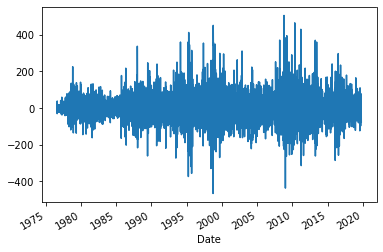

In [384]:
settle_noise.plot()

<AxesSubplot:xlabel='Date'>

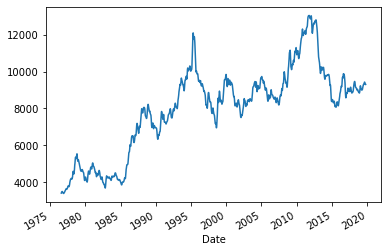

In [385]:
settle_trend.plot()

In [386]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:


df= yen_futures[['Settle']].copy()
df

noise = settle_noise 
trend = settle_trend
df['noise'] = noise 
df['trend'] = trend

# Observe the result 
df.head()

,Settle,noise,trend
Date,,,
1976-08-02,3401.0,10.174688,3390.825312
1976-08-03,3401.0,6.238556,3394.761444
1976-08-04,3401.0,2.296065,3398.703935
1976-08-05,3401.0,-1.663044,3402.663044
1976-08-06,3401.0,-5.650464,3406.650464


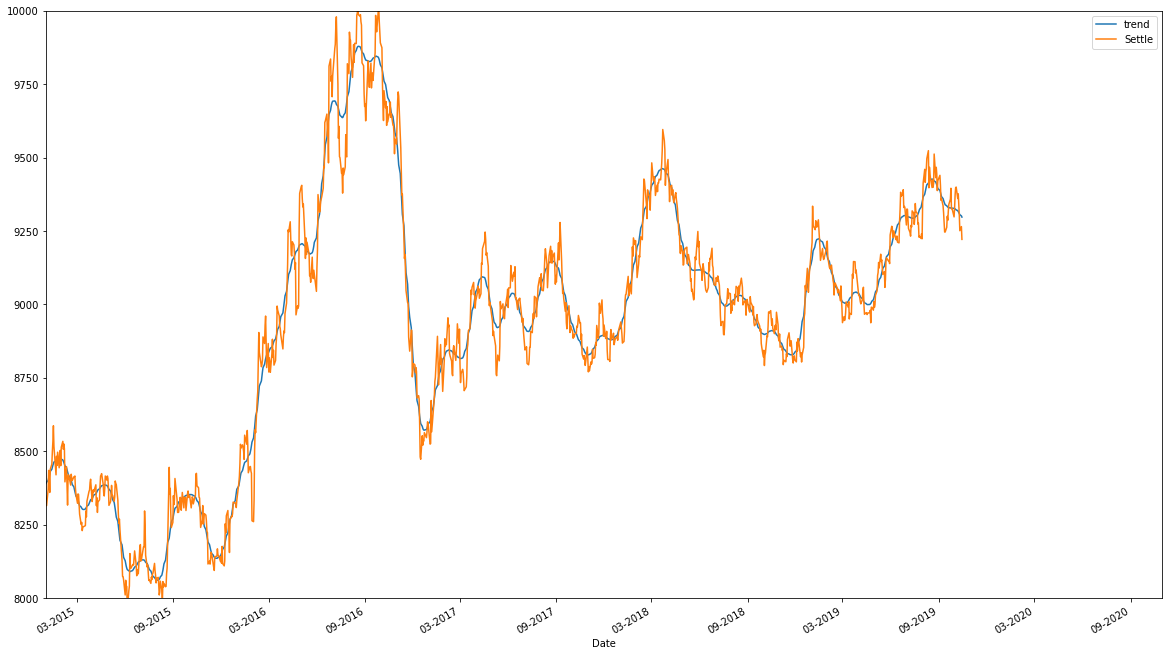

In [387]:
# Plot the Settle Price vs. the Trend for 2015 to the present

lines = df.plot.line(y={'Settle', 'trend'}, figsize=(20,12))
date_form = DateFormatter("%m-%Y")
lines.xaxis.set_major_formatter(date_form)
lines.set_xlim(pd.Timestamp('2015-01-01'), pd.Timestamp('2020-10-31'))
lines.set_ylim(8000,10000)
lines.xaxis.set_major_locator(mdates.MonthLocator(interval=6))


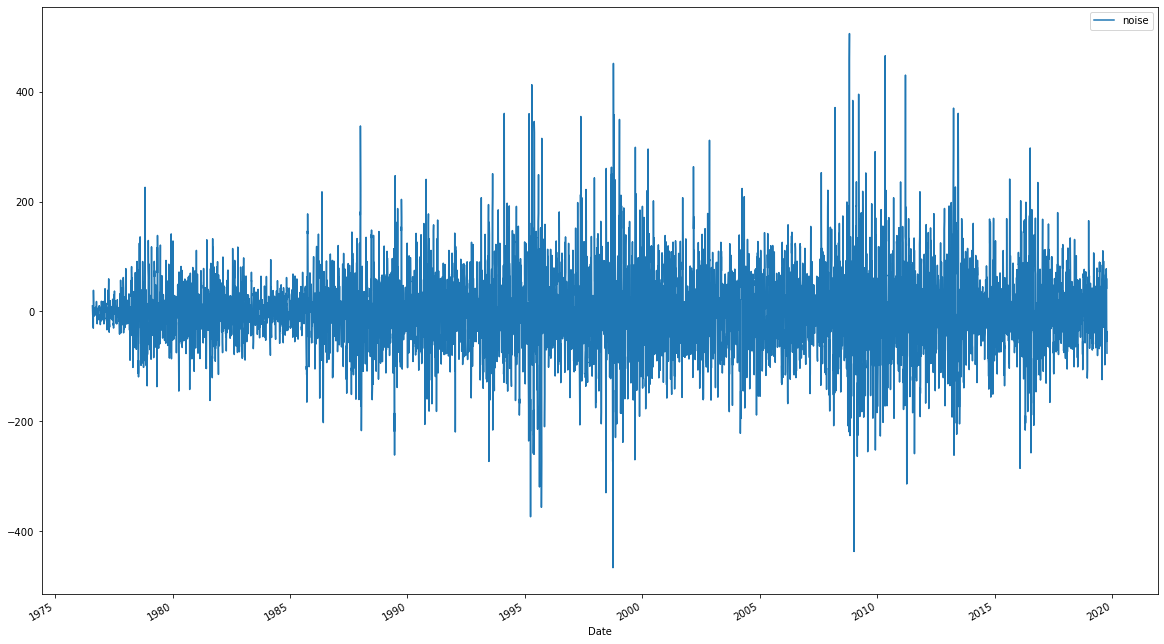

In [388]:
# Plot the Settle Noise

lines = df.plot.line(y={'noise'}, figsize=(20,12))

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [389]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [390]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA 

# Estimate and ARMA model using statsmodels (use order=(2, 1))

model = ARMA(returns.values, order=(2,1)) 
# Fit the model and assign it to a variable called results

results = model.fit() 

In [391]:
# Output model summary results:

results.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                10901
Model:                     ARMA(2, 1)   Log Likelihood              -11512.994
Method:                       css-mle   S.D. of innovations              0.696
Date:                Wed, 25 Nov 2020   AIC                          23035.987
Time:                        10:43:33   BIC                          23072.470
Sample:                             0   HQIC                         23048.284
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0116      0.007      1.748      0.080      -0.001       0.025
ar.L1.y       -0.6659      0.417     -1.598      0.110      -1.482       0.151
ar.L2.y       -0.0074      0.010     -0.770      0.441      -0.026       0.011
ma.L1.y        0.6610      0.417      1.587      0.113      -0.155       1.477
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.5277           +0.0000j            1.5277            0.5000
AR.2          -88.7991           +0.0000j           88.7991            0.5000
MA.1           -1.5129           +0.0000j            1.5129            0.5000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'5 Day Returns Forecast'}>

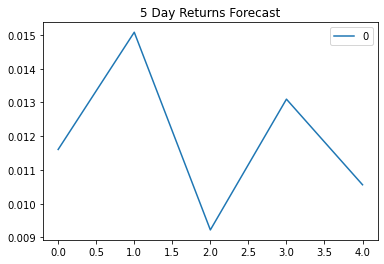

In [392]:
# Plot the 5 Day Returns Forecast

pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Returns Forecast") 

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [393]:
import statsmodels.api as sm

from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))

model = ARIMA(df['Settle'], order=(5, 1, 1))

# YOUR CODE HERE!
results = model.fit()

In [394]:
# Output model summary results:
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Settle   No. Observations:                10901
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -59614.572
Method:                       css-mle   S.D. of innovations             57.385
Date:                Wed, 25 Nov 2020   AIC                         119245.144
Time:                        10:43:37   BIC                         119303.517
Sample:                             1   HQIC                        119264.818
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.5346      0.526      1.017      0.309      -0.496       1.565
ar.L1.D.Settle     0.2258      0.595      0.379      0.704      -0.941       1.392
ar.L2.D.Settle    -0.0026      0.012     -0.223      0.823      -0.025       0.020
ar.L3.D.Settle    -0.0061      0.010     -0.594      0.552      -0.026       0.014
ar.L4.D.Settle    -0.0133      0.011     -1.244      0.213      -0.034       0.008
ar.L5.D.Settle    -0.0024      0.014     -0.178      0.859      -0.029       0.024
ma.L1.D.Settle    -0.2363      0.595     -0.397      0.691      -1.403       0.930
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.9129           -1.4193j            2.3820           -0.1016
AR.2            1.9129           +1.4193j            2.3820            0.1016
AR.3           -1.7087           -3.0612j            3.5058           -0.3310
AR.4           -1.7087           +3.0612j            3.5058            0.3310
AR.5           -5.8675           -0.0000j            5.8675           -0.5000
MA.1            4.2327           +0.0000j            4.2327            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'5 Day Futures Price Forecast'}>

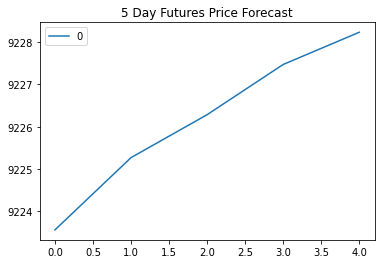

In [395]:
# Plot the 5 Day Price Forecast

pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Futures Price Forecast") 

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [396]:
import arch 
from arch import arch_model

In [397]:
# Estimate a GARCH model:

model = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1) 
# Fit the model

res = model.fit(disp="off") 

In [398]:
# Summarize the model results

res.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -10917.0
Distribution:                  Normal   AIC:                           21842.0
Method:            Maximum Likelihood   BIC:                           21871.2
                                        No. Observations:                10901
Date:                Wed, Nov 25 2020   Df Residuals:                    10897
Time:                        10:43:41   Df Model:                            4
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.6567e-03  3.287e-03      1.417      0.157 [-1.785e-03,1.110e-02]
alpha[1]       0.0404  1.388e-02      2.913  3.585e-03  [1.322e-02,6.764e-02]
alpha[2]   5.1841e-12  2.165e-02  2.395e-10      1.000 [-4.243e-02,4.243e-02]
beta[1]        0.9509  2.247e-02     42.328      0.000      [  0.907,  0.995]
=============================================================================

Covariance estimator: robust
"""

In [399]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [400]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above

forecasts = res.forecast(start='2019-10-15', horizon=forecast_horizon)
forecasts

In [401]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,7.461108,7.507407,7.553026,7.597982,7.642288


In [402]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2019-10-15
h.1,7.461108
h.2,7.507407
h.3,7.553026
h.4,7.597982
h.5,7.642288


<AxesSubplot:>

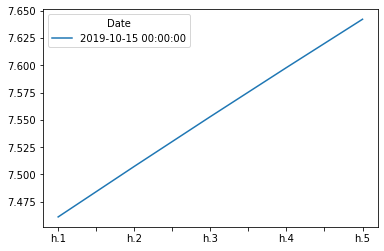

In [403]:
# Plot the final forecast

final.plot() 

---

# Conclusions

Based on your time series analysis, would you buy the yen now?

Based on the analysis, ARMA model shows the long term trend for yen is upward. If I want to buy and long term investemnet I would buy yen. But the 5 day forecsting models both ARMA and ARIMA is showing high volatity so in shorter period I would not buy yen.

Is the risk of the yen expected to increase or decrease?

After time series analysis of 5 day forecasting it is showing that risk of the yen to be expecetd increase due to high volatility.

Based on the model evaluation, would you feel confident in using these models for trading?


ARIMA models are popular forecasting methods with lots of applications in the domain of finance. Using a linear combination of past returns and residuals, an attempt can be made to predict future returns. Alternatively, when returns exhibit a change in variance over time, this family of models runs into problems. This phenomenon is often present and also known as conditional variance, or volatility clustering. GARCH models able to model this irregularity. Both types of models are therefore combined in practice to optimize forecasting performance.

For long term trading I would use ARMA/ARIMA model.
For short term trading or investment, volatility variances I would prefer GARCH model.
